### sys.path 보정

In [1]:
import os, sys
PROJECT_ROOT = os.path.abspath("..") 
print("PROJECT_ROOT:", PROJECT_ROOT)
print("Exists src?:", os.path.isdir(os.path.join(PROJECT_ROOT, "src")))
print("List root:", os.listdir(PROJECT_ROOT)[:20])

if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

%load_ext autoreload
%autoreload 2


PROJECT_ROOT: /home/mun03/work/projects/cv-lab1/malaria-detection/project
Exists src?: True
List root: ['configs', 'notebook', 'src', '_olds']


'/home/mun03/work/projects/cv-lab1/projects/malaria-detection/src'

CWD: /home/mun03/work/projects/cv-lab1/projects/malaria-detection/src/notebook
sys.path[0:3]: ['/home/mun03/work/projects/cv-lab1/projects/malaria-detection/src', '/usr/lib/python312.zip', '/usr/lib/python3.12']


### Imports & Config 로드

In [2]:
from src.utils.config import load_config

cfg = load_config("../configs/exp001.yaml")
cfg

Config(run=RunCfg(name='exp001', out_dir='runs', seed=42), data=DataCfg(dataset='tfds:malaria', img_size=128, batch_size=32, val_split=0.2, test_split=0.0, shuffle_buffer=10000, num_parallel_calls='AUTOTUNE'), augment=AugmentCfg(enabled=True, random_flip=True, random_brightness=0.1, random_contrast=0.1), model=ModelCfg(name='simple_cnn', num_classes=2, dropout=0.2, base_trainable=True), train=TrainCfg(epochs=10, optimizer='adam', learning_rate=0.001, loss='sparse_categorical_crossentropy', monitor='val_auc', monitor_mode='max', early_stop_patience=5))

### Seed 고정 + run_dir 생성

In [3]:
import tensorflow as tf
from src.utils.seed import set_global_seed
from src.utils.io import make_run_dir, copy_config, save_metadata, try_git_commit_hash

set_global_seed(cfg.run.seed)
run_dir = make_run_dir(cfg.run.out_dir, cfg.run.name)
copy_config("../configs/exp001.yaml", run_dir)

save_metadata(
    run_dir,
    {
        "git_commit": try_git_commit_hash(),
        "tensorflow": tf.__version__,
        "seed": cfg.run.seed,
    },
)
run_dir

2026-01-18 04:30:35.097635: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-18 04:30:35.157393: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-18 04:30:36.629637: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


'runs/exp001_2026-01-18_043037'

### Dataset 생성 (pipeline 재사용)

In [4]:
from src.data.pipeline import build_datasets

train_ds, val_ds, test_ds, num_classes = build_datasets(cfg)
num_classes

I0000 00:00:1768678271.824728   17036 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5560 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


2

2026-01-18 04:31:26.038445: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:396] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


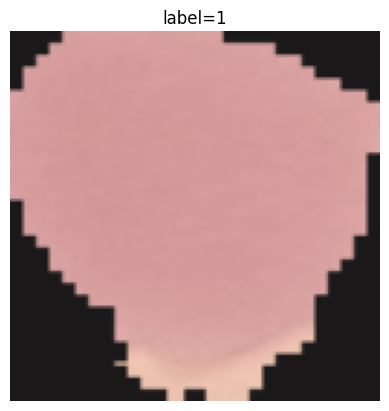

In [ ]:
import matplotlib.pyplot as plt

x, y = next(iter(train_ds))
plt.figure()
plt.imshow(x[0].numpy())
plt.title(f"label={int(y[0])}")
plt.axis("off")
plt.show()

### Model 생성 + compile

In [6]:
from src.models.model_factory import build_model

model = build_model(cfg, num_classes=num_classes)
model.summary()

Model: "simple_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ probs (Dense)                   │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,402 (368.76 KB)

 Trainable params: 93,954 (367.01 KB)

 Non-trainable params: 448 (1.75 KB)

In [10]:
def build_optimizer(name: str, lr: float):
    name = name.lower()
    if name == "adam":
        return tf.keras.optimizers.Adam(lr)
    if name == "sgd":
        return tf.keras.optimizers.SGD(lr, momentum=0.9)
    raise ValueError(name)


model.compile(
    optimizer=build_optimizer(cfg.train.optimizer, cfg.train.learning_rate),
    loss=cfg.train.loss,
    metrics=[
        tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        # tf.keras.metrics.AUC(name="auc"),
    ],
)

### Callbacks 설정 + fit

In [ ]:
import os

ckpt_dir = os.path.join(run_dir, "checkpoints")
tb_dir = os.path.join(run_dir, "logs")
best_sm = os.path.join(run_dir, "best_savedmodel.h5")

callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir=tb_dir),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(ckpt_dir, "last.weights.h5"),
        save_weights_only=True,
        save_best_only=False,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(ckpt_dir, "best.weights.h5"),
        save_weights_only=True,
        monitor=cfg.train.monitor,
        mode=cfg.train.monitor_mode,
        save_best_only=True,
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor=cfg.train.monitor,
        mode=cfg.train.monitor_mode,
        patience=cfg.train.early_stop_patience,
        restore_best_weights=True,
    ),
]

In [12]:
history = model.fit(
    train_ds, validation_data=val_ds, epochs=cfg.train.epochs, callbacks=callbacks
)
model.save(best_sm)
best_sm

Epoch 1/10


2026-01-18 04:35:58.444456: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91701


  4/689 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.4395 - loss: 0.8286  

I0000 00:00:1768678562.009691   17413 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


689/689 ━━━━━━━━━━━━━━━━━━━━ 27s 31ms/step - accuracy: 0.8316 - loss: 0.3976 - val_accuracy: 0.7857 - val_loss: 0.6600
Epoch 2/10


/home/mun03/venvs/tf220/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:276: UserWarning: Can save best model only with val_auc available.
  if self._should_save_model(epoch, batch, logs, filepath):
/home/mun03/venvs/tf220/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.9223 - loss: 0.2341 - val_accuracy: 0.9354 - val_loss: 0.1832
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.9338 - loss: 0.2044 - val_accuracy: 0.9457 - val_loss: 0.1620
Epoch 4/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.9404 - loss: 0.1877 - val_accuracy: 0.9427 - val_loss: 0.1644
Epoch 5/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.9412 - loss: 0.1783 - val_accuracy: 0.9412 - val_loss: 0.1699
Epoch 6/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.9395 - loss: 0.1836 - val_accuracy: 0.9454 - val_loss: 0.1659
Epoch 7/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.9425 - loss: 0.1719 - val_accuracy: 0.9539 - val_loss: 0.1558
Epoch 8/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.9444 - loss: 0.1697 - val_accuracy: 0.6915 - val_loss: 1.0459
Epoch 9/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.9472 - loss: 0.1625 - val_accurac

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=runs/exp001_2026-01-18_043037/best_savedmodel.

### 학습 시각화

In [13]:
import pandas as pd

hist = pd.DataFrame(history.history)
hist.tail()

,accuracy,loss,val_accuracy,val_loss
5,0.939493,0.183619,0.945382,0.165874
6,0.942532,0.171897,0.953910,0.155807
7,0.944437,0.169685,0.691526,1.045851
8,0.947204,0.162490,0.899837,0.254863
9,0.944936,0.169543,0.929595,0.184275


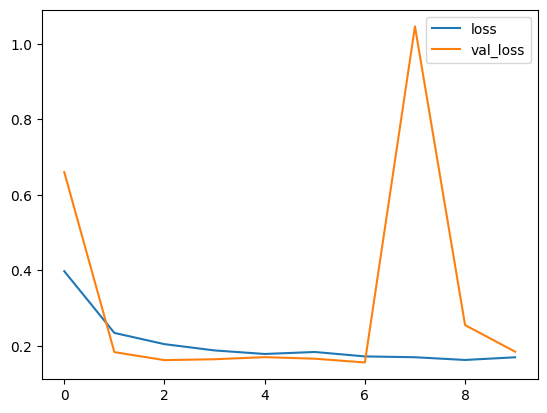

In [14]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(hist["loss"], label="loss")
plt.plot(hist["val_loss"], label="val_loss")
plt.legend()
plt.show()

### Eval / Confusion matrix

In [15]:
import numpy as np
from src.utils.report import save_eval_report

ds = test_ds if test_ds is not None else val_ds

y_true, y_pred = [], []
for bx, by in ds:
    p = model.predict(bx, verbose=0)
    y_pred.append(np.argmax(p, axis=1))
    y_true.append(by.numpy())

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

save_eval_report(run_dir, y_true, y_pred, num_classes)

2026-01-18 05:12:17.509608: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
